## 1. Load data

In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch
from torch import nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import pickle
import time
%matplotlib inline

## 2. Create function to generate dataset at specific size

In [2]:
def get_transforms(target_size, is_train=True):
    trans = [
        transforms.Resize((target_size, target_size)),
        transforms.Pad( (29-target_size) // 2 ),
    ]
    if is_train:
        trans += [
            transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.6),
            transforms.RandomApply([transforms.RandomAffine(10, translate=(0.1,0.1), scale=(0.9,1.1), shear=3)], p=0.6),
        ]
    trans.append(transforms.ToTensor())
    dataset_transforms = transforms.Compose(trans)
    return dataset_transforms

def get_datasets(target_size=29):
    assert target_size <= 29 and target_size % 2 == 1

    train_transforms = get_transforms(target_size)
    train_dataset = datasets.MNIST('./data', train=True, transform=train_transforms, target_transform=None, download=True)
    
    torch.manual_seed(42) # keep same seed everytime
    train_size = int(0.8 * len(train_dataset))
    valid_size = len(train_dataset) - train_size    
    train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

    test_transforms = get_transforms(target_size, is_train=False)
    test_dataset = datasets.MNIST('./data', train=False, transform=test_transforms, target_transform=None, download=True)

    return dict(train=train_dataset, valid=valid_dataset, test=test_dataset)

def show_tensor_image(image):
    plt.imshow(transforms.ToPILImage()(image), cmap='gray');
    
def get_dataloaders(data):
    dataloaders = dict(
        train=DataLoader(data['train'], batch_size=256, shuffle=True, num_workers=6),
        valid=DataLoader(data['valid'], batch_size=128, shuffle=False, num_workers=6),
        test=DataLoader(data['test'], batch_size=32, shuffle=False, num_workers=6),
    )
    return dataloaders

In [3]:
data = get_datasets(target_size=21)
len(data['train']), len(data['test'])

(48000, 10000)

In [4]:
x, y = data['train'][0]
type(x), type(y), x.shape

(torch.Tensor, int, torch.Size([1, 29, 29]))

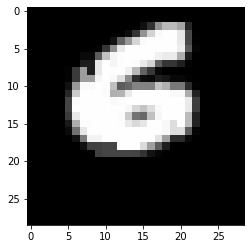

In [5]:
show_tensor_image(x)

## 3. Create model class and get_model function

In [6]:
class MCDNN1(nn.Module):
    def __init__(self):
        super(MCDNN1, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class MCDNN2(nn.Module):
    def __init__(self):
        super(MCDNN2, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class MCDNN3(nn.Module):
    def __init__(self):
        super(MCDNN3, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5)),
            ('relu2', nn.ReLU()),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class MCDNN4(nn.Module):
    def __init__(self):
        super(MCDNN4, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=3)),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1)

class ScaledTanh(nn.Module):
    def __init__(self):
        super(ScaledTanh, self).__init__()

    def forward(self, x):
        return x*torch.tanh(x)


class MCDNN(nn.Module):
    def __init__(self):
        super(MCDNN, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', ScaledTanh()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5)),
            ('relu2', ScaledTanh()),
            ('pool2', nn.MaxPool2d(kernel_size=3)),
            ('flatten', Flatten()),
            ('fc1', nn.Linear(in_features=40*3*3, out_features=150)),
            ('relu3', ScaledTanh()),
            ('fc2', nn.Linear(in_features=150, out_features=10)),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

data = get_datasets(target_size=21)
dataloaders = get_dataloaders(data)
batch_x, batch_y = next(iter(dataloaders['train']))
print('first layer', MCDNN1()(batch_x).shape)
print('second layer', MCDNN2()(batch_x).shape)
print('third layer', MCDNN3()(batch_x).shape)
print('fourth layer', MCDNN4()(batch_x).shape)
print('final layer', MCDNN()(batch_x).shape)

first layer torch.Size([256, 20, 26, 26])
second layer torch.Size([256, 20, 13, 13])
third layer torch.Size([256, 40, 9, 9])
fourth layer torch.Size([256, 40, 3, 3])
final layer torch.Size([256, 10])


## 4. Create training function to train a model given ```dataloaders['train']``` and ```dataloaders['valid']```

In [ ]:
def train_model(dataloaders, model, loss_func, optimizer, scheduler=None, device="cuda:0", epochs=1, save_func=None):
    
    def train_epoch():
        model.train()
        total_loss = 0
        for batch_x, batch_y in dataloaders['train']:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            loss = loss_func(pred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None: scheduler.step()
            
            total_loss += loss.item()
        return total_loss / len(dataloaders['train'])
            
    def valid_epoch():
        model.eval()
        total_loss, total_error, total_count = 0, 0, 0
        with torch.no_grad():
            for batch_x, batch_y in dataloaders['valid']:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                pred = model(batch_x)
                loss = loss_func(pred, batch_y)
                total_loss += loss.item()
                
                y_pred = torch.argmax(pred, dim=1)
                total_error += torch.sum(y_pred != batch_y).item()
                total_count += batch_y.shape[0]

        return total_loss / len(dataloaders['valid']), total_error / total_count
    
    train_loss, valid_loss, valid_error = [], [], []
    best_valid_loss = float('inf')
    pbar = tqdm(range(epochs), total=epochs)
    save_message = ''
    for epoch in pbar:
        train_loss.append(train_epoch())
        vloss, verror = valid_epoch()
        valid_loss.append(vloss)
        valid_error.append(verror)
        pbar.set_description(f'epoch {epoch} current best {best_valid_loss*100:.3f}% error {verror*100:.3f}% {save_message}')
        if valid_error[-1] < best_valid_loss:
            best_valid_loss = valid_error[-1]
            if save_func is not None:
                save_message = save_func(model)
                pbar.set_description(f'epoch {epoch} new best {best_valid_loss*100:.3f}% error {verror*100:.3f}% {save_message}')
    return train_loss, valid_loss, valid_error
                
def save_func(target_size, column):
                
    def __save_func(model):
        model_path = f'./models/model_{target_size}_{column}.pth'
        torch.save(dict(state_dict=model.state_dict()), model_path)
        return f'{model_path}'
    
    return __save_func

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) == nn.Conv2D:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [8]:
data = get_datasets(target_size=29)
dataloaders = get_dataloaders(data)

device = "cuda:0"
epochs = 2
model = MCDNN().to(device)
model.apply(init_weights)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_model(dataloaders, model, loss_func, optimizer, epochs=epochs, device=device, save_func=save_func(29, 10));

epoch 1 new best 3.725% error 3.725% ./models/model_29_10.pth: 100%|██████████| 2/2 [00:11<00:00,  5.99s/it]    


## 5. Train all models and save best models to ```./models``` folder

In [9]:
TARGET_SIZES = [29, 27, 25, 21, 19, 17, 15]

In [10]:
### comment/uncomment the following code for training all models

for target_size in TARGET_SIZES:
    for column in range(5):
        data = get_datasets(target_size=target_size)
        dataloaders = get_dataloaders(data)

        device = "cuda:0"
        epochs = 100
        model = MCDNN().to(device)
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
        train_model(dataloaders, model, loss_func, optimizer, epochs=epochs, device=device, save_func=save_func(target_size, column))

epoch 99 current best 0.758% error 0.858% ./models/model_29_0.pth: 100%|██████████| 100/100 [09:27<00:00,  5.68s/it]
epoch 99 current best 0.725% error 0.858% ./models/model_29_1.pth: 100%|██████████| 100/100 [09:34<00:00,  5.75s/it]
epoch 99 current best 0.817% error 0.833% ./models/model_29_2.pth: 100%|██████████| 100/100 [09:27<00:00,  5.68s/it]
epoch 99 current best 0.783% error 0.833% ./models/model_29_3.pth: 100%|██████████| 100/100 [09:33<00:00,  5.73s/it]
epoch 99 current best 0.800% error 0.867% ./models/model_29_4.pth: 100%|██████████| 100/100 [09:33<00:00,  5.74s/it]
epoch 99 current best 0.842% error 0.933% ./models/model_27_0.pth: 100%|██████████| 100/100 [09:24<00:00,  5.64s/it]
epoch 99 current best 0.742% error 0.933% ./models/model_27_1.pth: 100%|██████████| 100/100 [09:28<00:00,  5.69s/it]
epoch 99 current best 0.750% error 0.950% ./models/model_27_2.pth: 100%|██████████| 100/100 [09:27<00:00,  5.67s/it]
epoch 99 current best 0.742% error 0.925% ./models/model_27_3.pt

## 6. Evaluate (generate table 1)

In [13]:
# Helper function to generate probability column of a model
def get_column(input_image, model, target_size, device):
    transform = get_transforms(target_size, is_train=False)
    input_tensor = transform(input_image)[None,...]
    with torch.no_grad():
        column = model(input_tensor.to(device)).cpu()
    return column

def get_error_rate(prediction, ground_truth):
    assert len(prediction) == len(ground_truth)
    n_error = sum([1 if x != y else 0 for x, y in zip(prediction, ground_truth)])
    return n_error / len(ground_truth)

In [14]:
# Load test dataset without any transform, we will transform using above helper function
test_dataset = datasets.MNIST('./data', train=False, transform=None, target_transform=None, download=True)

# Load all 35 saved models
models = {}
device = "cuda:0"
for target_size in TARGET_SIZES:
    for column in range(5):
        model_id = f'{target_size}_{column}'
        model_path = f'./models/model_{model_id}.pth'
        model = MCDNN()
        model.load_state_dict(torch.load(model_path)['state_dict'])
        model.to(device)
        model.eval()
        models[model_id] = model

# generate all predictions on test dataset
ground_truth = [y for x, y in test_dataset]
predictions = {k: [] for k, v in models.items()}
predictions.update({f'{target_size}': [] for target_size in TARGET_SIZES})
predictions['all'] = []

start_time = time.time()
for idx, (x, y) in enumerate(test_dataset):
    columns = {k: None for k, v in models.items()}
    all_net_avg = 0
    ### switch between the following two lines to test and to run all models
    # for target_size in [29]: #, 27, 25, 21, 19, 17, 15]: 
    for target_size in TARGET_SIZES:
        five_net_avg = 0
        for column in range(5):
            model_id = f'{target_size}_{column}'
            column = get_column(x, models[model_id], target_size, device)
            columns[model_id] = column
            predictions[model_id].append( torch.argmax(column).item() ) # argmax works here because there is only ONE sample
            
            five_net_avg += column
            all_net_avg += column

        five_net_avg /= 5 # take 5-column average
        predictions[f'{target_size}'].append( torch.argmax(five_net_avg).item() )

    all_net_avg /= 35 # take 35-column average
    predictions['all'].append( torch.argmax(all_net_avg).item() )
    
    if idx % 500 == 0:
        print(idx, f'{time.time()-start_time:.3f} sec')

## save results after a long experiment so that we could run analysis later
## always save raw results so that we could run different analysis later
with open('./results/predictions_with_augmentation.pkl', 'wb') as f:
    pickle.dump((predictions, ground_truth), f)

0 0.045 sec
500 20.725 sec
1000 41.040 sec
1500 61.340 sec
2000 81.621 sec
2500 101.774 sec
3000 122.051 sec
3500 142.447 sec
4000 162.721 sec
4500 183.017 sec
5000 203.286 sec
5500 223.681 sec
6000 244.080 sec
6500 264.349 sec
7000 284.744 sec
7500 305.222 sec
8000 325.836 sec
8500 346.368 sec
9000 367.641 sec
9500 388.360 sec


In [15]:
# load experiment results to run analysis, independent from above code 
with open('./results/predictions_with_augmentation.pkl', 'rb') as f:
    predictions, ground_truth = pickle.load(f)

def print_error_rate(model_id):
    error_rate = get_error_rate(predictions[model_id], ground_truth)
    print(f'{model_id} {error_rate*100:.2f}%')

for target_size in TARGET_SIZES:
    for column in range(5):
        print_error_rate( f'{target_size}_{column}' )
        
for target_size in TARGET_SIZES:
    print_error_rate( f'{target_size}' )

print_error_rate( 'all' )

29_0 0.59%
29_1 0.46%
29_2 0.52%
29_3 0.47%
29_4 0.47%
27_0 0.55%
27_1 0.46%
27_2 0.46%
27_3 0.48%
27_4 0.44%
25_0 0.55%
25_1 0.50%
25_2 0.51%
25_3 0.54%
25_4 0.49%
21_0 0.62%
21_1 0.58%
21_2 0.67%
21_3 0.57%
21_4 0.64%
19_0 0.51%
19_1 0.66%
19_2 0.57%
19_3 0.63%
19_4 0.68%
17_0 0.59%
17_1 0.69%
17_2 0.65%
17_3 0.65%
17_4 0.60%
15_0 0.81%
15_1 0.61%
15_2 0.68%
15_3 0.76%
15_4 0.67%
29 0.43%
27 0.44%
25 0.42%
21 0.57%
19 0.49%
17 0.51%
15 0.57%
all 0.39%
